# Notebook 9: Advanced Models Part 1
We can now begin explore more sophisticated statistical models.
This notebook contains the first part: lasso regression.

In [15]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.formula.api as sm
import pickle
from collections import Counter
import sklearn as sk
from sklearn.preprocessing import Imputer
from sklearn import linear_model
from sklearn.grid_search import GridSearchCV

In [16]:
# Load cleaned NCD data from pickled files
out = open('data/clean/deaths_100k.p', 'r')
deaths_100k = pickle.load(out)
out.close()
out = open('data/clean/risk.p', 'r')
risk_of_death = pickle.load(out)
out.close()
out = open('data/clean/crops.p', 'r')
crops = pickle.load(out)
out.close()
out = open('data/clean/meat.p', 'r')
meat = pickle.load(out)
out.close()
out = open('data/clean/var_desc_livestock.p', 'r')
livestock_desc = pickle.load(out)
out.close()
out = open('data/clean/var_desc_crops.p', 'r')
crops_desc = pickle.load(out)
out.close()

# load cleaned food data with redundant variables removed
out = open('data/final/food_1970_2000_cleaned.p', 'r')
food_1970_2000_cleaned = pickle.load(out)

# Get response variables
deaths_100k_all_2000 = deaths_100k['all'][2000]
deaths_100k_cancer_2000 = deaths_100k['cancer'][2000]
deaths_100k_cardio_2000 = deaths_100k['cardio'][2000]
deaths_100k_diabetes_2000 = deaths_100k['diabetes'][2000]
deaths_100k_resp_2000 = deaths_100k['resp'][2000]

risk_of_death_2000 = risk_of_death[2000]

time_period = range(1970, 2000)

# Calculate the mean for each crop/meat over the period 1970-2000
food_1970_2000 = pd.DataFrame(index=risk_of_death.index)

for crop in crops.iterkeys():
    food_1970_2000[crop] = crops[crop][time_period].mean(axis=1)
    
for m in meat.iterkeys():
    food_1970_2000[m] = meat[m][time_period].mean(axis=1)

# list of countries to drop due to being less than 50% full
countries_to_drop = []

for index, row in food_1970_2000.iterrows():
    if row.isnull().sum() > len(row) / 2:
        countries_to_drop.append(index)

In [20]:
# Plots bar graph of coefficient estimates for regression model and given significance level 
def plot_sig_coeffs(fit, sig_level):
    # Filter for predictors with p-values less than provided cutoff
    significant = fit.pvalues[fit.pvalues <= sig_level]
    # Plot coefficient estimates for predictors with p < 0.1 
    fit.params[significant.index].sort_values().plot(kind="bar", 
        title="Coefficient Estimates for Predictors with p < 0.1", 
        )

# I. Lasso Regression
To do variable selection efficiently, as explained in Baseline Models and Revised Baseline Models.

## Risk of Death in 2000 as Response Variable

We use `sklearn`'s `GridSearchCV` function to find the best hyperparameter ($\alpha$) value.

In [17]:
lasso = linear_model.Lasso(alpha = 1.0)
X = food_1970_2000_cleaned.values
y_death_lasso = risk_of_death_2000.drop(countries_to_drop).values
lasso.fit(X, y_death_lasso)
lasso.score(X, y_death_lasso)
lasso.coef_
params = {
    'alpha': [0.3,0.6,1.0,1.3,1.6,2.0,2.3,2.6,3.0,4.0,5.0, 6.0, 7.0, 8.0] + 
             [4.3, 4.6, 5.3, 5.6, 6.0, 6.3, 6.6, 7.0],
    'fit_intercept': [True, False],
    'normalize': [True, False],
}

CV_model = GridSearchCV(lasso, param_grid=params, cv=5)
CV_model.fit(X, y_death_lasso)
CV_model.best_params_

{'alpha': 5.6, 'fit_intercept': True, 'normalize': False}

We then fit the model using the optimum alpha provided to fit the model using `statsmodels`.

In [18]:
# Fit linear model with risk of death in 2000 as response variable
risk_2000_model_lasso = sm.OLS(risk_of_death_2000.drop(countries_to_drop), food_1970_2000_cleaned)
risk_2000_results_lasso = risk_2000_model_lasso.fit_regularized(alpha = 5.6)
print(risk_2000_results_lasso.summary())

                            OLS Regression Results                            
Dep. Variable:                   2000   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     23.64
Date:                Wed, 14 Dec 2016   Prob (F-statistic):           1.32e-31
Time:                        16:12:42   Log-Likelihood:                -445.06
No. Observations:                 154   AIC:                             1054.
Df Residuals:                      72   BIC:                             1303.
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------
Plantains 

Checking the same diagnostics as before, while the Condition Number is much smaller (indicating a reduced likelihood of multicollinearity affecting the model), for the model considering overall percentage risk of death in 2000 the residuals do not appear to be normally distributed (according to the Omnibus and Jarque-Bera Tests), so we should address that issue in follow-up models.

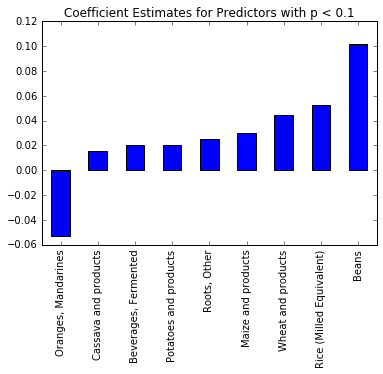

In [21]:
plot_sig_coeffs(risk_2000_results_lasso, 0.1)

## Deaths per 100k from All Causes as Response Variable

In [22]:
lasso = linear_model.Lasso(alpha = 1.0)
X = food_1970_2000_cleaned
y_death_100k_cancer_lasso = deaths_100k_all_2000.drop(countries_to_drop).sort_index().loc[food_1970_2000_cleaned.index].values
lasso.fit(X, y_death_100k_cancer_lasso)
lasso.score(X, y_death_100k_cancer_lasso)
lasso.coef_
params = {
    'alpha': [0.3,0.6,1.0,1.3,1.6,2.0,2.3,2.6,3.0,4.0,5.0],
    'fit_intercept': [True, False],
    'normalize': [True, False],
}

CV_model = GridSearchCV(lasso, param_grid=params, cv=5)
CV_model.fit(X, y_death_100k_cancer_lasso)
CV_model.best_params_

{'alpha': 1.3, 'fit_intercept': True, 'normalize': True}

In [23]:
# Fit linear model with risk of death in 2000 as response variable
deaths100k_model_lasso = sm.OLS(deaths_100k_all_2000.drop(countries_to_drop).sort_index().loc[food_1970_2000_cleaned.index], 
                                food_1970_2000_cleaned)
deaths100k_results_lasso = deaths100k_model_lasso.fit_regularized(alpha = 1.3)
print(deaths100k_results_lasso.summary())

                            OLS Regression Results                            
Dep. Variable:                   2000   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     37.89
Date:                Wed, 14 Dec 2016   Prob (F-statistic):           1.54e-38
Time:                        16:14:09   Log-Likelihood:                -925.62
No. Observations:                 154   AIC:                             2015.
Df Residuals:                      72   BIC:                             2264.
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------
Plantains 

Similarly, when considering age-standardized mortality rate as the response variable, according to the Omnibus and Jarque-Bera Tests the residuals do not appear normally distributed, which we should address in follow-up models.

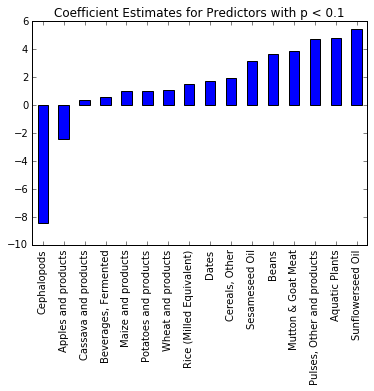

In [24]:
plot_sig_coeffs(deaths100k_results_lasso, 0.1)

## Deaths per 100k from Cancer as Response Variable

In [26]:
lasso = linear_model.Lasso(alpha = 1.0)
y_death_100k_cancer_lasso = deaths_100k_cancer_2000.drop(countries_to_drop).sort_index().loc[food_1970_2000_cleaned.index]
lasso.fit(X.values, y_death_100k_cancer_lasso.values)
lasso.score(X.values, y_death_100k_cancer_lasso.values)
lasso.coef_
params = {
    'alpha': [0.3,0.6,1.0,1.3,1.6,2.0,2.3,2.6,3.0,4.0,5.0],
    'fit_intercept': [True, False],
    'normalize': [True, False],
}

CV_model = GridSearchCV(lasso, param_grid=params, cv=5)
CV_model.fit(X, y_death_100k_cancer_lasso)
CV_model.best_params_

{'alpha': 0.6, 'fit_intercept': True, 'normalize': True}

In [27]:
# Fit linear model with risk of death in 2000 as response variable
deaths100k_cancer_model_lasso = sm.OLS(y_death_100k_cancer_lasso, X)
deaths100k_cancer_results_lasso = deaths100k_cancer_model_lasso.fit_regularized(alpha = 0.6)
print(deaths100k_cancer_results_lasso.summary())

                            OLS Regression Results                            
Dep. Variable:                   2000   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     24.78
Date:                Wed, 14 Dec 2016   Prob (F-statistic):           2.74e-32
Time:                        16:14:43   Log-Likelihood:                -704.16
No. Observations:                 154   AIC:                             1572.
Df Residuals:                      72   BIC:                             1821.
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------
Plantains 

When considering the age-standardized mortality rate from cancer, once again the Omnibus and Jarque-Bera Tests indicate that the residuals are not normally distributed.

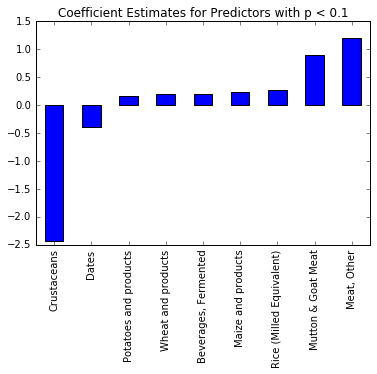

In [28]:
plot_sig_coeffs(deaths100k_cancer_results_lasso, 0.1)

## Deaths per 100k from Cardiovascular Disease as Response Variable

In [29]:
lasso = linear_model.Lasso(alpha = 1.0)
y_death_100k_cardio_lasso = deaths_100k_cardio_2000.drop(countries_to_drop).sort_index().loc[food_1970_2000_cleaned.index]
lasso.fit(X.values, y_death_100k_cardio_lasso.values)
lasso.score(X.values, y_death_100k_cardio_lasso.values)
lasso.coef_
params = {
    'alpha': [0.3,0.6,1.0,1.3,1.6,2.0,2.3,2.6,3.0,4.0,5.0],
    'fit_intercept': [True, False],
    'normalize': [True, False],
}

CV_model = GridSearchCV(lasso, param_grid=params, cv=5)
CV_model.fit(X, y_death_100k_cardio_lasso)
CV_model.best_params_

{'alpha': 1.0, 'fit_intercept': True, 'normalize': True}

In [30]:
# Fit linear model with risk of death in 2000 as response variable
deaths100k_cardio_model_lasso = sm.OLS(y_death_100k_cardio_lasso, X)
deaths100k_cardio_results_lasso = deaths100k_cardio_model_lasso.fit_regularized(alpha = 1.0)
print(deaths100k_cardio_results_lasso.summary())

                            OLS Regression Results                            
Dep. Variable:                   2000   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     31.17
Date:                Wed, 14 Dec 2016   Prob (F-statistic):           1.21e-35
Time:                        16:15:54   Log-Likelihood:                -842.23
No. Observations:                 154   AIC:                             1848.
Df Residuals:                      72   BIC:                             2097.
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------
Plantains 

According to both the Omnibus and Jarque-Bera Tests, we fail to reject the null hypothesis that the residuals are normally distributed in this model, with the age-standardized mortality rate from cardiovascular disease as the response variable.

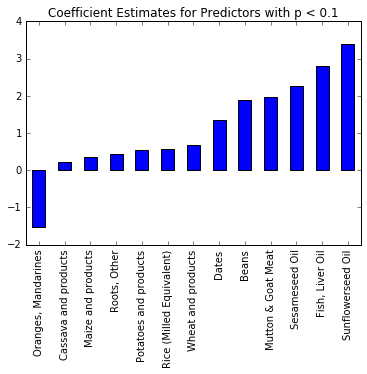

In [31]:
plot_sig_coeffs(deaths100k_cardio_results_lasso, 0.1)

## Deaths per 100k from Diabetes as Response Variable

In [32]:
lasso = linear_model.Lasso(alpha = 1.0)
y_death_100k_diabetes_lasso = deaths_100k_diabetes_2000.drop(countries_to_drop).sort_index().loc[food_1970_2000_cleaned.index]
lasso.fit(X.values, y_death_100k_diabetes_lasso.values)
lasso.score(X.values, y_death_100k_diabetes_lasso.values)
lasso.coef_
params = {
    'alpha': [0.3,0.6,1.0,1.3,1.6,2.0,2.3,2.6,3.0,4.0,5.0],
    'fit_intercept': [True, False],
    'normalize': [True, False],
}

CV_model = GridSearchCV(lasso, param_grid=params, cv=5)
CV_model.fit(X, y_death_100k_diabetes_lasso)
CV_model.best_params_

{'alpha': 0.3, 'fit_intercept': True, 'normalize': True}

In [33]:
# Fit linear model with risk of death in 2000 as response variable
deaths100k_diabetes_model_lasso = sm.OLS(y_death_100k_diabetes_lasso, X)
deaths100k_diabetes_results_lasso = deaths100k_diabetes_model_lasso.fit_regularized(alpha = 0.3)
print(deaths100k_diabetes_results_lasso.summary())

                            OLS Regression Results                            
Dep. Variable:                   2000   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     7.048
Date:                Wed, 14 Dec 2016   Prob (F-statistic):           2.61e-15
Time:                        16:16:34   Log-Likelihood:                -620.47
No. Observations:                 154   AIC:                             1405.
Df Residuals:                      72   BIC:                             1654.
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------
Plantains 

When considering the age-standardized mortality rate from diabetes as the response variable, both the Omnibus and Jarque-Bera Tests reject the null hypothesis, claiming that there is significant evidence that the residuals are not normally distributed.

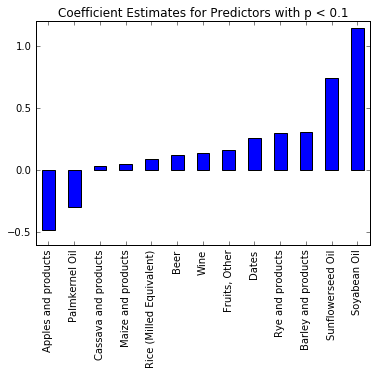

In [34]:
plot_sig_coeffs(deaths100k_diabetes_results_lasso, 0.1)

## Deaths per 100k from Respiratory Disease as Response Variable

In [35]:
lasso = linear_model.Lasso(alpha = 1.0)
y_death_100k_resp_lasso = deaths_100k_resp_2000.drop(countries_to_drop).sort_index().loc[food_1970_2000_cleaned.index]
lasso.fit(X.values, y_death_100k_resp_lasso.values)
lasso.score(X.values, y_death_100k_resp_lasso.values)
lasso.coef_
params = {
    'alpha': [0.3,0.6,1.0,1.3,1.6,2.0,2.3,2.6,3.0,4.0,5.0],
    'fit_intercept': [True, False],
    'normalize': [True, False],
}

CV_model = GridSearchCV(lasso, param_grid=params, cv=5)
CV_model.fit(X, y_death_100k_resp_lasso)
CV_model.best_params_

{'alpha': 0.6, 'fit_intercept': True, 'normalize': True}

In [36]:
# Fit linear model with risk of death in 2000 as response variable
deaths100k_resp_model_lasso = sm.OLS(y_death_100k_resp_lasso, X)
deaths100k_resp_results_lasso = deaths100k_resp_model_lasso.fit_regularized(alpha = 0.6)
print(deaths100k_resp_results_lasso.summary())

                            OLS Regression Results                            
Dep. Variable:                   2000   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     8.144
Date:                Wed, 14 Dec 2016   Prob (F-statistic):           4.41e-17
Time:                        16:17:17   Log-Likelihood:                -666.48
No. Observations:                 154   AIC:                             1497.
Df Residuals:                      72   BIC:                             1746.
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------
Plantains 

When considering the age-standardized mortality rate from respiratory disease as the response variable, both the Omnibus and Jarque-Bera Tests reject the null hypothesis of normality in the residuals.

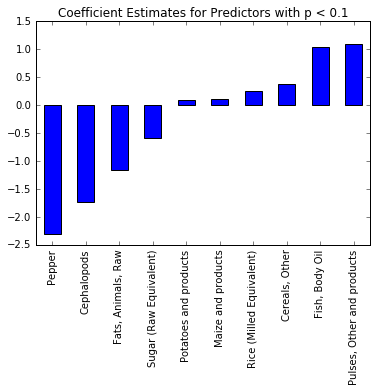

In [37]:
plot_sig_coeffs(deaths100k_resp_results_lasso, 0.1)